# Special method `SSV2stab` for large, mildly stiff problems

`SSV2stab` is based on the stabilized Runge-Kutta-Chebyshev method of [Sommeijer, Shampine and Verwer](https://doi.org/10.1016/S0377-0427(97)00219-7). It is similar to the Fortran code [RKC](https://www.netlib.org/ode/), but translated to Python and adapted to Scipy's solve_ivp.

Stiff problems cannot be solved efficiently by explicit methods. In many relevant cases, stiffness is caused by a negative real pole far from the origin. Very small steps are needed with an explicit method to keep this pole inside the stability region. The trick of the `SSV2stab` is that it has a variable number of stages per step. The stability region stretches quadratically along the negative real axis with the number of stages. Therefore, it is more efficient to include more stages than to take smaller steps. Step size is also variable such that accuracy can be controlled.

This explicit method has a fixed order of 2. This is appropriate because the order of the spatial discretization is typically limited too. It is not useful to have a very low error due to time discretization if the error due to space discretization is much larger. Therefore, relatively coarse steps are OK and a low order method is efficient for this.

So why not just use an implicit method like `BDF`? Implicit methods need to solve linear systems with the Jacobian of the ODE. This is costly if the system is large, even though very good sparse methods are available. Therefore, implicit methods need to take larger steps to compensate for the extra cost per step, to be competitive. Although implicit method remain stable, they do loose accuracy with larger step size. So step size is typically limited by accuracy and explicit methods can be more efficient.

There are limits to this of course. The problem could be too stiff and that stiffness could be negligible for the solution. If this is the case, or if the problem is small, an implicit method would probably work better.

One more remark before the demonstration of the method: the constraints of scipy's `solve_ivp` do not favor large problems. The complete solution is kept in memory. Writing previous time steps to disk is not possible. Further development to overcome this and perhaps with numba to improve performance may be needed to make this method really useful for the case it was designed for by Sommeijer. Though then it may be easier to just use the original Fortran code instead.

This notebook needs more memory and calculation time than usual.

## Combustion problem

The problems from the [paper](https://doi.org/10.1016/S0377-0427(97)00219-7) are reproduced. We start with the second one, a combustion problem with concentration $c$ and temperature $T$ fields PDEs:

$$ \dot{c} = \Delta c - D c e^{-\delta / T}, \qquad L \dot{T} = \Delta T - \alpha D c e^{-\delta / T} $$

The model geometry is the unit cube and spatial discretization is done with finite differences with 40 points in each direction. This results in $ 2 \times 40^3 = 128000 $ degrees of freedom and equations.

Initially both fields equal 1. Dirichlet boundary conditions are applied at $x, y, z = 1$ and Neumann boundary conditions at $x, y, z = 0$, to model symmetry.

This problem is coded with array operations and 3D arrays with extra nodes to apply the boundary conditions. The discretization along one direction looks like: 

$$ \times-|-\times--\times--\times--\times--|\times $$

with nodes $\times$ and boundaries $|$. The Neumann boundary at the left is halfway the nodes and the Dirichlet boundary at the right is at the last node. Only the $N=4$ nodes between the boundaries are degrees of freedom for the discretized ODE. The spacing between the nodes is $h=1/(N+0.5)$. For the actual problem we will use N=40, as mentioned.

In [10]:
import numpy as np

L = 0.9                                     # Lewis Number
alpha = 1.                                  # heat release
delta = 20.                                 # activation energy
R = 5.                                      # reaction rate
D = R * np.exp(delta) / (alpha * delta)     # Damkohler number
args = (L, alpha, delta, D)

N = 40

# expanded work arrays
_c = np.ones((N+2, N+2, N+2))
_T = np.ones((N+2, N+2, N+2))

def Lap(A, h):
    """Return Laplacian from finite differences"""
    lap = (1. / h**2) * (-6 * A[1:-1, 1:-1, 1:-1] +
           A[:-2, 1:-1, 1:-1] + A[2:, 1:-1, 1:-1] + 
           A[1:-1, :-2, 1:-1] + A[1:-1, 2:, 1:-1] + 
           A[1:-1, 1:-1, :-2] + A[1:-1, 1:-1, 2:] )
    return lap

def fun(t, y, L, alpha, delta, D, _c=_c, _T=_T, N=N):
    c = y[:N**3].reshape(N, N, N)
    T = y[N**3:].reshape(N, N, N)
    
    # fill work arrays with current solution
    _c[1:-1, 1:-1, 1:-1] = c
    _T[1:-1, 1:-1, 1:-1] = T
    
    # Neumann BCs
    _c[0, :, :] = _c[1, :, :]
    _c[:, 0, :] = _c[:, 1, :]
    _c[:, :, 0] = _c[:, :, 1]
    _T[0, :, :] = _T[1, :, :]
    _T[:, 0, :] = _T[:, 1, :]
    _T[:, :, 0] = _T[:, :, 1]
    # (Dirichlet BCs are constant)
    
    Dce = D * c * np.exp(-delta / T)
    h = 1. / (N + 0.5)
    
    # ODEs from discretized PDEs
    dc = Lap(_c, h) - Dce
    dT = (Lap(_T, h) + alpha * Dce)/L
    
    return np.concatenate([dc.reshape(-1),
                           dT.reshape(-1)])

The first solve will be for a slightly longer interval than in the paper to show the boundary layers at the end of the solution.

In [11]:
from scipy.integrate import solve_ivp
from extensisq import SSV2stab

t_span = [0, 0.33]      # boundary layers at 0.33, not at 0.3
y0 = np.ones(2*N**3)
tol = 1e-4
t_eval = [0.2, 0.25, 0.3, 0.31, 0.32, 0.33]

sol = solve_ivp(fun, t_span, y0, method=SSV2stab, rtol=tol, atol=tol, 
                args=args, t_eval=t_eval)

The output times in `t_eval` are chosen to show the evolution of the solution. Notice that the steps are more concentrated near the end. In the first few steps, the temperature increases, then combustions occurs at the origin. A sharp front travels quickly to the Dirichlet boundaries. Finally a steady state develops with boundary layers. This is the temperature field in the $x=0$ plane (and without the boundary nodes):

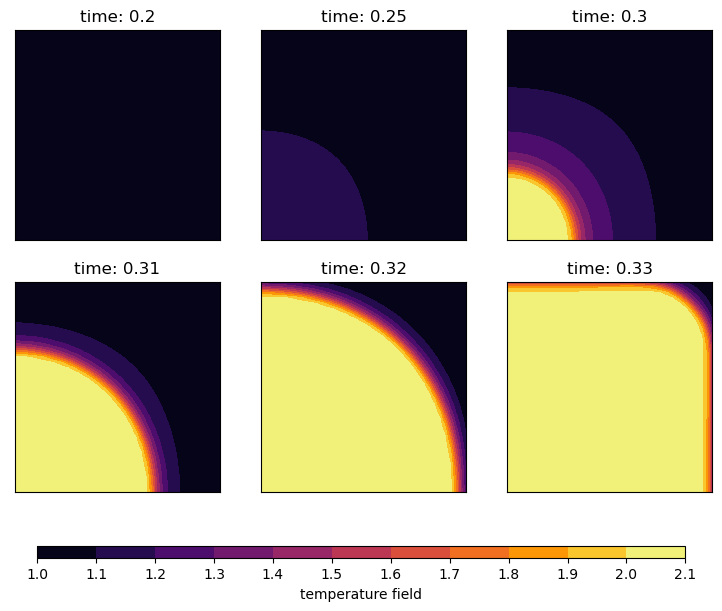

In [12]:
import matplotlib.pyplot as plt

levels = np.linspace(1, 2.1, 12)
fig, axs = plt.subplots(2, 3, figsize=(9,6))
for t, s, ax in zip(t_eval, sol.y.T, axs.flatten()):
    M = s[N**3:].reshape(N, N, N)[0,:,:]
    ct = ax.contourf(M, levels=levels, cmap='inferno')
    # ax.colorbar(ticks=levels, label='temperature')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'time: {t}')

cax = plt.axes([0.15, 0, 0.72, 0.02])
plt.colorbar(ct, cax=cax, label='temperature field', orientation='horizontal',
             ticks=levels)
plt.show()

We see boundary layer develop after $t=0.32$. The paper mentions that there are already boundary layers at $t=0.3$. So is the problem modelled correctly, and does `SSV2stab` work well? To find out, I will repeat the calculations of the paper.

First calculate an accurate reference solution.

In [13]:
t_span = [0, 0.30]      # reduce to interval from paper

tol = 1e-8
ref = solve_ivp(fun, t_span, y0, method=SSV2stab, rtol=tol, atol=tol, 
                args=args, t_eval=[0.3]).y[:,-1]

Now solve for a range of tolerances:

In [14]:
from extensisq.sommeijer import maxm, NFS, nfesig
from time import perf_counter

# now solve for a range of tolerances:
tols = np.logspace(-4, -7, 4)

print(' Tol\tError\t Steps \tf-evals\taverage\tf-sigma\t CPU\ts-max')
for tol in tols:
    timer = perf_counter()
    sol = solve_ivp(fun, t_span, y0, method=SSV2stab, rtol=tol, atol=tol, 
                    args=args)
    cpu = perf_counter() - timer
    err = np.abs(sol.y[:, -1] - ref).max()
    nfs = NFS[()]
    nsteps = sol.t.size - 1 + nfs
    nfev = sol.nfev
    avg = nfev/nsteps
    print(f'{tol:.0e}\t{err:.2g}\t{nsteps:>3} ({NFS[()]})\t {nfev:>4}\t'
          f' {avg:>4.1f} \t  {nfesig}\t{cpu:>4.1f}\t {maxm[()]}')

 Tol	Error	 Steps 	f-evals	average	f-sigma	 CPU	s-max
1e-04	0.54	 51 (1)	  525	 10.3 	  21	 4.2	 36
1e-05	0.18	124 (0)	  781	  6.3 	  27	 8.3	 29
1e-06	0.037	270 (0)	 1270	  4.7 	  39	10.0	 20
1e-07	0.0068	581 (0)	 2147	  3.7 	  65	13.8	 14


The table shows for the different tolerances: the max error, the number of steps (failed steps in parenthesis), the number of function evaluations for the steps, the average number of evaluations per step, the number of function evaluations that were used for detection of the spectral radius the cpu time and the maximum number of stages per step.

The results show that higher accuracy results in more steps, but also in fewer evaluations per step. This is expected, because the stability region scales with step size. So the total cost of the integration increases with higher accuracy, but the cost per step reduces. The number of function evaluations to estimate the spectral radius (f-sigma) increases though. Apparently the spectral radius is estimated more often. (The code estimates it after each failed step and after 25 successful steps.)

Comparing this to Table 3 in the [paper](https://doi.org/10.1016/S0377-0427(97)00219-7), we see that only the CPU column, and the error for stricter tolerances are different. Furthermore, the maximum number of stages (last column) conforms to the maximum in Figure 2 of the paper (20 for tolerance 1e-6). This is quite strong evidence that the method works as it should, despite the late appearance of the boundary conditions in the solution observed earlier.

## Heat transfer problem

The other problem from the paper is a linear heat transfer problem. This problem is repeated as well, because it shows some special arguments that make the solver more efficient in some cases:
* 'rho_jac': The user can supply a function f(t, y) that returns the spectral radius as a float, or a conservative estimate of it. This saves on functions evaluations to estimate it (column 'f-sigma' above).
* 'const_jac': Let the method know when the Jacobian, and therefore the spectral radius, is constant. This is True for linear problems by definition. When rho_jac is defined, it is called each step if const_jac is False.

This problem has Dirichlet boundary conditions all around. Therefore the grid looks like:
$$ \times|--\times--\times--\times--\times--|\times $$
And the node spacing is $h=1/(N+1)$. The problem is solved in a similar way as before.

Solution is the analytic solution of the *continuous* problem.

New is the rho_jac function that estimates the spectral radius using [Gershgorin circle theorem](https://en.wikipedia.org/wiki/Gershgorin_circle_theorem). The cost of evaluation this function is clearly negligible.

In [15]:
def solution(x, y, z, t):
    """solution of the continuous problem"""
    return np.tanh(5*x + 10*y + 7.5*z - (2.5 + 5*t))

def f(x, y, z, t):
    """heat source"""
    s = solution(x, y, z, t)
    return 362.5*(s - s**3) + 5*s**2 - 5

N = 39
x = np.linspace(0., 1., N+2)
y = np.linspace(0., 1., N+2)
z = np.linspace(0., 1., N+2)
X, Y, Z = np.meshgrid(x, y, z)
Twork = solution(X, Y, Z, 0)
y0 = Twork[1:-1, 1:-1, 1:-1].copy().reshape(-1)

def fun(t, y, work=Twork, X=X, Y=Y, Z=Z, N=N):
    """derivative function"""
    
    # apply BCs all around (Dirichlet only)
    work[0,:,:] = solution(X[0,:,:], Y[0,:,:], Z[0,:,:], t)
    work[-1,:,:] = solution(X[-1,:,:], Y[-1,:,:], Z[-1,:,:], t)
    work[:,0,:] = solution(X[:,0,:], Y[:,0,:], Z[:,0,:], t)
    work[:,-1,:] = solution(X[:,-1,:], Y[:,-1,:], Z[:,-1,:], t)
    work[:,:,0] = solution(X[:,:,0], Y[:,:,0], Z[:,:,0], t)
    work[:,:,-1] = solution(X[:,:,-1], Y[:,:,-1], Z[:,:,-1], t)
    
    # insert current values of dofs
    work[1:-1, 1:-1, 1:-1] = y.reshape(N, N, N)
    
    # calculate derivative
    h = 1./(N + 1.)
    dy = Lap(Twork, h) + f(X, Y, Z, t)[1:-1, 1:-1, 1:-1]
    
    return dy.reshape(-1)

def rho_jac(t, y, N=N):
    """spectral radius estimate"""
    h = 1./(N + 1.)
    return 12 / h**2

We again need a reference solution of the discrete problem with the $N$ value that we use. This is needed because it is not the same as the know analytic continuous solution.

In [16]:
tol = 1e-8
t_span = (0, 0.7)

ref = solve_ivp(fun, t_span, y0, method=SSV2stab, rtol=tol, atol=tol,
                const_jac=True, rho_jac=rho_jac, t_eval=[0.7]).y[:,-1]

Next, we solve for a range of tolerances and create a table that compares the results.

In [17]:
# now solve for a range of tolerances:
tols = np.logspace(-1, -6, 6)
solc = solution(X, Y, Z, 0.7)[1:-1,1:-1,1:-1].reshape(-1)

print(' Tol\t Error\t Steps \tf-evals\taverage\tf-sigma\t CPU\ts-max\terror-c')
for tol in tols:
    timer = perf_counter()
    sol = solve_ivp(fun, t_span, y0, method=SSV2stab, rtol=tol, atol=tol, 
                    const_jac=True, rho_jac=rho_jac, dense_output=True)
    cpu = perf_counter() - timer
    err = np.abs(sol.y[:, -1] - ref).max()
    nfs = NFS[()]
    nsteps = sol.t.size - 1 + nfs
    nfev = sol.nfev
    avg = nfev/nsteps
    err2 = np.abs(sol.y[:, -1] - solc).max()
    print(f'{tol:.0e}\t{err:6.1e}\t{nsteps:>3} ({NFS[()]})\t {nfev:>4}\t'
          f' {avg:>4.1f} \t  {nfesig}\t{cpu:>4.1f}\t {maxm[()]}\t {err2:<6.2}')

 Tol	 Error	 Steps 	f-evals	average	f-sigma	 CPU	s-max	error-c
1e-01	8.9e-03	  6 (1)	  402	 67.0 	  0	 2.8	 132	 0.011 
1e-02	1.7e-03	 15 (4)	  729	 48.6 	  0	 5.4	 85	 0.0043
1e-03	3.7e-04	 27 (2)	  786	 29.1 	  0	 8.5	 40	 0.0037
1e-04	3.9e-05	 57 (0)	 1087	 19.1 	  0	15.3	 26	 0.0036
1e-05	4.3e-06	129 (1)	 1682	 13.0 	  0	24.3	 20	 0.0036
1e-06	6.5e-07	262 (0)	 2445	  9.3 	  0	22.2	 12	 0.0036


This table can be compared to Table 1 in the paper. It is identical except for the CPU column. The f-sigma column is added to show that no evaluation are needed for the spectral radius estimate anymore if `rho_jac` is given.

The error-c column is also interesting. It is the error with respect to the continuous solution (the 'Error' column is regarding the discrete solution). The error-c plateaus at 0.0036. This drives home the point that was made in the introduction that high accuracy is typically not useful in typical method of lines problems. A tolerance between 1e-2 and 1e-3 seems optimal for this problem with $N=40$. For more accuracy, $N$ should be increased next to lowering `tol`. This results in much higher computational costs, because the number of DOFs scale with $N^3$.

## Conclusions

`SSV2stab` is an interesting method that stretches the stability domain in order to solve mildly stiff problems explicitly. It is most useful for larger problems such as those discretized PDE's (method of lines). This type of problems is arguably not the best fit for solve_ivp, or even for Python in general, but extensisq's `SSV2stab` may be useful for some experimentation and development nevertheless.